### Key Dectection Trial Code

The code below will not be annotated. It involes some exploration in data synthesis in order to bolster an insufficient dataset. This code will be referenced, but not included in the main project notebook.

---

In [1]:
import librosa as lb
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import PowerTransformer

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('PSD_data.csv')
df.tail()

,C,C#,D,Eb,E,F,F#,G,G#,A,Bb,B,key,file_name
599,444.679318,1992.525567,881.530065,29352.763156,9418.584581,15539.874667,1628.458134,920.985402,374.658092,161.838549,418.136025,1029.672037,E minor,1949099.LOFI.mp3
600,1911.868097,3234.755145,331.638425,4626.063993,517.644691,1587.764537,5230.362085,2116.399489,3354.809556,231.714128,4071.239069,59.723742,Eb minor,3372108.LOFI.mp3
601,1898.384718,1570.736300,1367.747783,1722.823444,3911.420452,9024.409445,5528.623968,3033.380395,3400.976997,2437.430222,1899.910791,1801.813055,F minor,4928111.LOFI.mp3
602,1576.440993,8050.270935,538.722500,1351.704226,2415.039681,161.361424,792.974874,1927.834072,10424.336922,8631.877463,2587.752843,9578.205826,Db minor,5308082.LOFI.mp3
603,1895.641807,1019.851448,589.889393,461.978466,116.642039,1085.809364,314.119005,1213.787700,680.040845,1280.994173,1214.870462,1499.104816,C major,997308.LOFI.mp3


In [3]:
df.dtypes

C            float64
C#           float64
D            float64
Eb           float64
E            float64
F            float64
F#           float64
G            float64
G#           float64
A            float64
Bb           float64
B            float64
key           object
file_name     object
dtype: object

Let's get rid of the file extensions and LOFI nonsense. We can then use these file names as the dataframe index.

In [4]:
df['file_name'] = df['file_name'].str[:-9]
df.set_index('file_name', inplace=True)
df.head()

,C,C#,D,Eb,E,F,F#,G,G#,A,Bb,B,key
file_name,,,,,,,,,,,,,
3424038,750.308707,4691.414029,1612.918772,319.253306,2335.771952,875.178168,484.621728,425.606940,9693.569146,7651.337192,1195.471723,444.589791,Db minor
1164898,4531.097606,887.006296,514.470259,568.688686,1220.777055,1578.884060,960.696350,2447.356108,633.341837,1187.834155,1299.876750,2360.462509,C major
1105632,34503.311286,8137.526044,25858.143295,2084.856302,154.049128,208.675112,135.055361,645.079718,238.924311,433.882390,1189.280108,5773.303616,C minor
3313070,582.980910,314.385464,1535.620626,245.699869,1372.465021,731.753825,897.287874,5411.305329,1914.269964,3970.659863,1204.547106,4388.782289,B minor
3228297,415.673224,900.211661,1329.573290,56.167929,176.089533,109.277736,1505.355256,757.495392,2101.972227,4032.907101,1464.530047,2344.920782,B minor


We will need to doctor some of the data. I see the need to normalize each pitch as a fraction of the 'total PSD' and clean up some sharp and flat notation to be consistent with the pitch bins we plan on using (e.g. Db should be labeled as C#). You'll see below that there are only 24 unique keys, which is what we want, but the notation just bothers me. So let's make it right.

In [5]:
len(df['key'].unique())

24

In [6]:
df.loc[df['key'] == 'Db minor', 'key'] = 'C# minor'
df.loc[df['key'] == 'Db major', 'key'] = 'C# major'
df.loc[df['key'] == 'D# minor', 'key'] = 'Eb minor'
df.loc[df['key'] == 'D# major', 'key'] = 'Eb major'
df.loc[df['key'] == 'Gb minor', 'key'] = 'F# minor'
df.loc[df['key'] == 'Gb major', 'key'] = 'F# major'
df.loc[df['key'] == 'Ab minor', 'key'] = 'G# minor'
df.loc[df['key'] == 'Ab major', 'key'] = 'G# major'
df.loc[df['key'] == 'A# minor', 'key'] = 'Bb minor'
df.loc[df['key'] == 'A# minor', 'key'] = 'Bb minor'

len(df['key'].unique())

24

With that squared away, let's take a look at how much representation of each possible key we have in our dataset. You'll note some obvious imbalance. We may need to account for this later in our training and cross-validation.

In [7]:
df.groupby(['key']).size()

key
A major     11
A minor     54
B major      5
B minor     32
Bb major     5
Bb minor    28
C major     15
C minor     53
C# major     1
C# minor    25
D major     10
D minor     40
E major     10
E minor     48
Eb major     9
Eb minor    36
F major      9
F minor     73
F# major     5
F# minor    31
G major      8
G minor     62
G# major     5
G# minor    29
dtype: int64

Now we can normalize the power values for each pitch.

In [8]:
pitch_labels = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']
df['power_sum'] = df[pitch_labels].sum(axis=1)
for label in pitch_labels:
    df[label] = df[label] / df['power_sum']
df.head()

,C,C#,D,Eb,E,F,F#,G,G#,A,Bb,B,key,power_sum
file_name,,,,,,,,,,,,,,
3424038,0.024616,0.153918,0.052917,0.010474,0.076633,0.028713,0.015900,0.013963,0.318030,0.251028,0.039221,0.014586,C# minor,30480.041453
1164898,0.249092,0.048762,0.028282,0.031263,0.067111,0.086797,0.052813,0.134540,0.034817,0.065300,0.071459,0.129764,C major,18190.491671
1105632,0.434758,0.102537,0.325825,0.026270,0.001941,0.002629,0.001702,0.008128,0.003011,0.005467,0.014985,0.072746,C minor,79362.086670
3313070,0.025830,0.013930,0.068039,0.010886,0.060810,0.032422,0.039756,0.239759,0.084816,0.175928,0.053370,0.194454,B minor,22569.758141
3228297,0.027357,0.059247,0.087505,0.003697,0.011589,0.007192,0.099075,0.049854,0.138341,0.265425,0.096388,0.154330,B minor,15194.174179


Now we need to code our ouput in a way that we can work with. The key makes sense to us, but we ought to encode this using numbers 0-23. We can convert this back to the key each integer corresponds to when necessary.

Just like getting our flats and sharps in a harmonious alignment, we will have to take a bit of a brute force approach to this.

In [9]:
key_labels = ['C major', 'C minor', 'C# major', 'C# minor', 'D major', 'D minor', 
              'Eb major', 'Eb minor', 'E major', 'E minor', 'F major', 'F minor', 
              'F# major', 'F# minor', 'G major', 'G minor', 'G# major', 'G# minor',
              'A major', 'A minor', 'Bb major', 'Bb minor', 'B major', 'B minor']
df['key'].replace(key_labels, list(range(24)), inplace=True)
df.head()

,C,C#,D,Eb,E,F,F#,G,G#,A,Bb,B,key,power_sum
file_name,,,,,,,,,,,,,,
3424038,0.024616,0.153918,0.052917,0.010474,0.076633,0.028713,0.015900,0.013963,0.318030,0.251028,0.039221,0.014586,3,30480.041453
1164898,0.249092,0.048762,0.028282,0.031263,0.067111,0.086797,0.052813,0.134540,0.034817,0.065300,0.071459,0.129764,0,18190.491671
1105632,0.434758,0.102537,0.325825,0.026270,0.001941,0.002629,0.001702,0.008128,0.003011,0.005467,0.014985,0.072746,1,79362.086670
3313070,0.025830,0.013930,0.068039,0.010886,0.060810,0.032422,0.039756,0.239759,0.084816,0.175928,0.053370,0.194454,23,22569.758141
3228297,0.027357,0.059247,0.087505,0.003697,0.011589,0.007192,0.099075,0.049854,0.138341,0.265425,0.096388,0.154330,23,15194.174179


Okay, we are in a pretty good place with our data now. Let's do our final prep and train a few initial models.

First, split our data into train and test sets.

In [10]:
X = df.drop(['key', 'power_sum'], axis=1)
y = df['key']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((483, 12), (121, 12))

I originally attempted adding noise to certain clips in the training dataset, but didn't wind up with anything very fruitful. After a few afternoons trying to make this work, I think my next attempt will be attempting to synthesize data by creating fake songs. Let's see what we can 

In [11]:
y_train.groupby(y_train).size(), len(y_train.groupby(y_train).size()), sum(y_train.groupby(y_train).size())

(key
 0     12
 1     37
 2      1
 3     19
 4      8
 5     31
 6      6
 7     28
 8     10
 9     36
 10     8
 11    56
 12     4
 13    28
 14     6
 15    51
 16     4
 17    25
 18     7
 19    46
 20     4
 21    24
 22     3
 23    29
 Name: key, dtype: int64,
 24,
 483)

Check out how we got lucky and the one C# major clip is in our training dataset. We can work with this. We will generate some slight amount of noise and add it to under-represented keys. This alleviates imbalance and increases the size of our dataset.

We want our model to be able to handle a fair amount of noise. Let's try the following approach.

1. Generate synthetic data for under-represented keys by using data in those keys and adding random noise up to 3%. 

2. Double our newly balanced dataset by adding noise up to 3% for each sample.

NOTE: This will produce some samples that contain up to 6.09% noise as we stack noise onto our already synthetic data.

I'm choosing to augment any key with less than 10 samples in the training data so we need to augment the following keys:

- C# major
- D major
- Eb major
- F major
- F# major
- G major
- G# major
- A major
- Bb major
- B major

In [12]:
def noise_adder(clips: list, noise_pct: float) -> None:
    '''add noise to clips in argument list of magnitude +/- noise_pct %.
    X_train_aug dataframe contains appended data'''
    for clip in clips:
        if clip in X_train_aug.index:
            # distribute noise in positive and negative directions
            noise = (np.random.random(len(X_train.columns))-0.5) * (noise_pct*2) / 100
            temp = X_train_aug.loc[clip, :'B'].copy()
            temp += noise
            temp = temp.tolist()
            temp.append(X_train_aug.loc[clip, 'key'])
            X_train_aug.loc[len(X_train_aug.index)] = temp
    return

In [13]:
# encoded keys to augment
aug_keys = [2, 4, 6, 10, 12, 14, 16, 18, 20, 22]
# list of clips 
aug_clips = list(df[df['key'].isin(aug_keys)].index)

X_train_aug = X_train.copy()
X_train_aug['key'] = y_train

# add 15 data points to each key that needs help
for i in range(30):
    noise_adder(aug_clips, 2)

In [14]:
X_train_aug.shape

(2013, 13)

Now repeat with some noise to double our sample size.

In [15]:
noise_adder(list(X_train_aug.index.values), 1)
X_train_aug.shape

(4026, 13)

Check our imbalance. Still far from perfect, but better than it was.

In [16]:
X_train_aug.clip(lower=0, inplace=True)

In [17]:
X_train_aug.groupby('key').size()

key
0.0      24
1.0      74
2.0      62
3.0      38
4.0     496
5.0      62
6.0     372
7.0      56
8.0      20
9.0      72
10.0    496
11.0    112
12.0    248
13.0     56
14.0    372
15.0    102
16.0    248
17.0     50
18.0    434
19.0     92
20.0    248
21.0     48
22.0    186
23.0     58
dtype: int64

Now, let's attempt to retrain our models and see where we land.

In [18]:
y_train_aug = X_train_aug['key']
X_train_aug = X_train_aug.drop(['key'], axis=1)
X_train_aug.head(), y_train_aug.head()

(                  C        C#         D        Eb         E         F  \
 file_name                                                               
 2725286    0.004530  0.002679  0.004777  0.001417  0.004275  0.023987   
 4399289    0.089803  0.023898  0.153939  0.015780  0.152353  0.143661   
 3178155    0.133513  0.047105  0.035356  0.093976  0.054022  0.166917   
 4091478    0.007054  0.007349  0.005851  0.008703  0.036609  0.011413   
 4206954    0.041473  0.009316  0.159931  0.007266  0.018892  0.180994   
 
                  F#         G        G#         A        Bb         B  
 file_name                                                              
 2725286    0.227415  0.376670  0.025433  0.023210  0.238266  0.067339  
 4399289    0.010000  0.187798  0.041253  0.105647  0.049862  0.026006  
 3178155    0.061164  0.080218  0.150605  0.091228  0.056649  0.029248  
 4091478    0.010291  0.043103  0.171505  0.636572  0.032887  0.028662  
 4206954    0.258097  0.095167  0.076114  

In [19]:
svm = SVC(kernel='poly', degree=2)
svm.fit(X_train_aug, y_train_aug)

SVC(degree=2, kernel='poly')

In [20]:
svm.score(X_test, y_test)

0.39669421487603307

In [22]:
gnb = GaussianNB()
gnb.fit(X_train_aug, y_train_aug)

GaussianNB()

In [23]:
gnb.score(X_test, y_test)

0.2809917355371901

In [24]:
rfc = RFC(max_depth=10, max_features=7)
rfc.fit(X_train_aug, y_train_aug)

rfc.score(X_test, y_test)

0.30578512396694213

In [25]:
boost = xgb.XGBClassifier()
boost.fit(X_train_aug, y_train_aug)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [26]:
pred = boost.predict(X_test)
sum(pred == y_test.values)/len(pred)

0.4380165289256198

This doesn't provide enough value to implement. Let's try 'generating' songs. First, we build the index data of each scale.

In [27]:
def scale_generator() -> list:
    '''returns a 2d list containing notes in all major and minor scales'''
    chromatic = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']
    chrom_2oct = chromatic * 2
    major = [2,4,5,7,9,11]
    minor = [2,3,5,7,8,10]
    all_scales = []
    for index, note in enumerate(chromatic[:len(chrom_2oct)//2]):
        scale = [note]
        for i in major:
            scale.append(chrom_2oct[index + i])
        all_scales.append(scale)
        scale = [note]
        for j in minor:
            scale.append(chrom_2oct[index + j])
        all_scales.append(scale)
    return all_scales

all_scales = scale_generator()
all_scales

[['C', 'D', 'E', 'F', 'G', 'A', 'B'],
 ['C', 'D', 'Eb', 'F', 'G', 'G#', 'Bb'],
 ['C#', 'Eb', 'F', 'F#', 'G#', 'Bb', 'C'],
 ['C#', 'Eb', 'E', 'F#', 'G#', 'A', 'B'],
 ['D', 'E', 'F#', 'G', 'A', 'B', 'C#'],
 ['D', 'E', 'F', 'G', 'A', 'Bb', 'C'],
 ['Eb', 'F', 'G', 'G#', 'Bb', 'C', 'D'],
 ['Eb', 'F', 'F#', 'G#', 'Bb', 'B', 'C#'],
 ['E', 'F#', 'G#', 'A', 'B', 'C#', 'Eb'],
 ['E', 'F#', 'G', 'A', 'B', 'C', 'D'],
 ['F', 'G', 'A', 'Bb', 'C', 'D', 'E'],
 ['F', 'G', 'G#', 'Bb', 'C', 'C#', 'Eb'],
 ['F#', 'G#', 'Bb', 'B', 'C#', 'Eb', 'F'],
 ['F#', 'G#', 'A', 'B', 'C#', 'D', 'E'],
 ['G', 'A', 'B', 'C', 'D', 'E', 'F#'],
 ['G', 'A', 'Bb', 'C', 'D', 'Eb', 'F'],
 ['G#', 'Bb', 'C', 'C#', 'Eb', 'F', 'G'],
 ['G#', 'Bb', 'B', 'C#', 'Eb', 'E', 'F#'],
 ['A', 'B', 'C#', 'D', 'E', 'F#', 'G#'],
 ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
 ['Bb', 'C', 'D', 'Eb', 'F', 'G', 'A'],
 ['Bb', 'C', 'C#', 'Eb', 'F', 'F#', 'G#'],
 ['B', 'C#', 'Eb', 'E', 'F#', 'G#', 'Bb'],
 ['B', 'C#', 'D', 'E', 'F#', 'G', 'A']]

Generate songs. Add higher scaling to tonic, 4th, 5th, and 6th of each scale.

In [28]:
def song_maker(key: list) -> list:
    chromatic = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']
    synth_PSD = []
    for note in chromatic:
        if note in key:
            if note == key[0]:
                synth_PSD.append(np.random.normal(loc=0.5, scale=0.15) * 1.05)
            elif note in key[3:6]:
                synth_PSD.append(np.random.normal(loc=0.5, scale=0.15) * 1.02)
            else:
                synth_PSD.append(np.random.normal(loc=0.5, scale=0.15))
        if note not in key:
            synth_PSD.append(np.random.normal(loc=0.5, scale=0.1)**(2.5))
    synth_PSD = np.array(synth_PSD)
    synth_PSD = synth_PSD/sum(synth_PSD)
    return synth_PSD.tolist()

test = song_maker(all_scales[0])
test

[0.11066575566572748,
 0.027727810505443356,
 0.10933099474439534,
 0.01932223445711899,
 0.16674652410707486,
 0.11540553010580573,
 0.02197881583040771,
 0.14468563871886073,
 0.03334122185041342,
 0.12224598126834131,
 0.028915031966911562,
 0.09963446077949947]

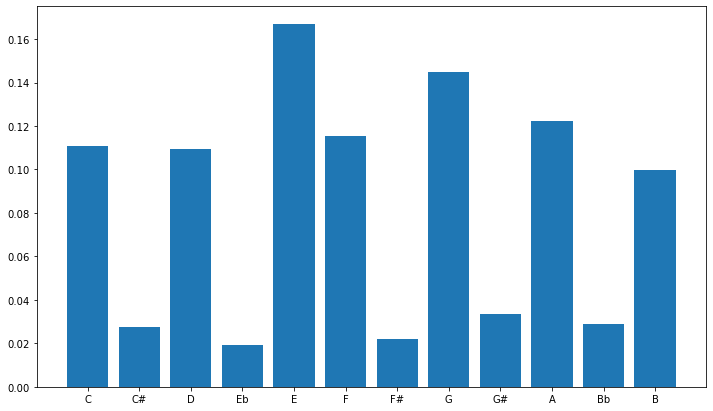

In [29]:
chromatic = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(chromatic, test)
plt.show()

In [30]:
chromatic = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']
chromatic.append('key')
synth_df = pd.DataFrame(columns=chromatic)

for index, scale in enumerate(all_scales):
    for i in range(300):
        new_song = song_maker(scale)
        new_song.append(index)
        synth_df.loc[len(synth_df.index)] = new_song

synth_df.clip(lower=0, inplace=True)
synth_df.shape

(7200, 13)

In [31]:
X_train_synth = synth_df.drop(['key'], axis=1)
y_train_synth = synth_df['key']

X_test = df.drop(['key', 'power_sum'], axis=1)
y_test = df['key']

In [32]:
boost = xgb.XGBClassifier()
boost.fit(X_train_synth, y_train_synth)

boost.score(X_test, y_test)

0.12086092715231789

In [33]:
svm = SVC(kernel='linear')
svm.fit(X_train_synth, y_train_synth)

svm.score(X_test, y_test)

0.17549668874172186

In [34]:
gnb = GaussianNB()
gnb.fit(X_train_synth, y_train_synth)

gnb.score(X_test, y_test)

0.16390728476821192

In [35]:
rfc = RFC(max_depth=6, max_features=8)
rfc.fit(X_train_synth, y_train_synth)

rfc.score(X_test, y_test)

0.09437086092715231